<h1>Projket ekonometrtia</h1>
<h2>Plik wykonywalny </h2>
<h2>Mateusz Jakubczak</h2>
<h3>Pobieranie danych

In [5]:
import csv
import warnings
from operator import itemgetter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from dython.nominal import associations
warnings.filterwarnings("ignore")
from scipy import stats
import math

In [6]:


#pare zmiennych globalnych
with open("linki.csv",newline="") as csvfile:
    reader = csv.reader(csvfile)
    links2 = list(reader)

#unpack list of list to list
links =  [item for sublist in links2[1:] for item in sublist]

znaczniki ={"Cena":"_1svub _lf05o _9a071_2MEB_"}

lista_parametrów = ["Cena","Stan","Typ telewizora","Marka",
                    "Technologia 3D", "Przekątna ekranu",
                    "Format HD","Rozdzielczość ekranu",
                    "Liczba złączy HDMI", "Technologia HDR",
                    "Klasa efektywności","Pobór mocy",
                    "Waga produktu"
                    ]



In [7]:
# uncoment to download data from links
# 
# with open(os.path.join(os.getcwd(), 'parametry.csv'), 'wb') as csvfile:
#      writer = unicodecsv.DictWriter(csvfile, fieldnames = lista_parametrów , delimiter = ';')
#      writer.writeheader()
# for link in links:
#     parmaetry = []
#     response = requests.get(link)
#    # print(response)
#     # znalazeinei ceny 
#     soup = BeautifulSoup(response.content,'html.parser')
#     #nalezalo by zastapic lepszym wyszukaniem
#     try:
#         cena = soup.find(class_=znaczniki["Cena"] )
#         # przejsc do dolu dwa razy po pierwszym elemencie 
#         cena = cena.contents[0].contents[0]
#     except:
#         AttributeError
#         print(link)
#         continue
#     parmaetry.append(cena)
#     #zanjdowanie tabeli parametrow 
#     pattern = re.compile(r'Parametry')
#     tabela = soup.find("h2",text= pattern)
#     #do gory dwa poziomy 
#     tabela = tabela.parent.parent
#    
#     for param in lista_parametrów[1:]:
#         try:
#             #najpier znajdz czy jest pole ktore nazywa sie dokladnie tak
#             stan_field = tabela.find(text = param)
#             #jesli nie ma takiego pola znajdz pierwsze które nazywa sie podobnie
#             if stan_field == None:  stan_field = tabela.find(text = re.compile(rf"{param}"))
#             #jesli nie znalioziona to wpisac -1
#             if stan_field == None: stan_field = -1
#             #up two nodes in tree then select content of second one
#             stan_field = stan_field.parent.parent.contents[1].contents[0]
#             try:
#                 if stan_field.contents != None : stan_field = stan_field.contents[0]
#             except:
#                 AttributeError   #dla pól co zawieraja w sobie linka 
#         except:
#             AttributeError 
#             print(f"Nie ma takiego parametru, parametr {param}") 
#             stan_field = -1
#         parmaetry.append(stan_field)
#     with open('parametry.csv', 'ab') as csvfile:
#         writer = unicodecsv.DictWriter(csvfile, fieldnames = lista_parametrów , delimiter = ';')
#         writer.writerow(dict(zip(lista_parametrów,parmaetry)))



In [8]:
def print(*args):
    __builtins__.print(*("%.2f" % a if isinstance(a, float) else a
                         for a in args))
    

def save_to_latex(content, name):
    try:
        latex = content.as_latex()
    except:
        latex = content
    with open(f"latex/{name}.tex", "w") as f: 
        f.write(latex)

<h3>Pre-processing and cleaning 

In [9]:
df = pd.read_csv("parametry.csv",delimiter=";")

print(df.dtypes)
#Cleaning
df["Cena"] = df["Cena"].apply(lambda s :''.join([i for i in s if i.isdigit()]))
df["Cena"] = df["Cena"].apply(pd.to_numeric)

#dla technoligi 3d w przypdako brakow zakladmy "nie" oraz zmiana do postaci binarnej 
df["Technologia 3D"] = df["Technologia 3D"].apply(lambda s : "nie" if s != "tak" else s)
df["Technologia 3D"] = df["Technologia 3D"].map({'tak': True, 'nie': False})
df["Technologia 3D"] = df["Technologia 3D"].astype('category')

#zmeinic przekonte na zmienna ciagłą 
df["Przekątna ekranu"] = df["Przekątna ekranu"].apply(lambda s :''.join([i for i in s if i.isdigit()]))
df["Przekątna ekranu"] = df["Przekątna ekranu"].apply(pd.to_numeric)

#polaczyc rozdzielczosc i format hd, poniewaz sa to pojecia rownowazne
#na niektorych ofertach jest podane tylko jedno 
print("Macierz czestości dla jakosci obrazu")
print(pd.crosstab(df["Rozdzielczość ekranu"],df["Format HD"]))
#potwierdza to macierz czestosci 
slownik =   {'3840 x 2160': '4K UHD',
             '7680 x 4320': '8K UHD',
             '1920 x 1080': 'Full HD',
             '1366 x 768': 'HD Ready'}
#first join
df['jakosc'] = df[[ 'Format HD','Rozdzielczość ekranu']].agg(';'.join, axis=1)
#then do operation on string
df['jakosc'] = df['jakosc'].apply(
    lambda s: s.split(sep = ";")[0] if s.split(sep = ";")[0] != "-1" and s.split(sep = ";")[0] != "inny"
    else slownik[s.split(sep = ";")[1]])
df["jakosc"] = df["jakosc"].astype('category')

#zmienic liczbe zleczy hdmi na categorical 
#mamy tutaj cztery mozliwe wartosci 
#df["Liczba złączy HDMI"]=df["Liczba złączy HDMI"].astype(pd.to_numeric)

#dla braku technologi HDR dac Nie 
df["Technologia HDR"] =df["Technologia HDR"].apply(lambda s: s if s != "-1" else "Nie")
df["Technologia HDR"]=df["Technologia HDR"].astype('category')

#klasy efektrywnosci -1 zamienic na inna 
df["Klasa efektywności"] = df["Klasa efektywności"].apply(lambda s: s if s != "-1" else "inna").astype("category")

#przeksztalcic pobor mocy do zmeinnej ciaglej 
df["Pobór mocy"] = df["Pobór mocy"].apply(lambda s :''.join([i for i in s if i.isdigit()]))
df["Pobór mocy"] = df["Pobór mocy"].apply(pd.to_numeric)

# usunac wage produktu, pozniewaz brakuje polowych danych 
print( df["Waga produktu"].value_counts("-1")[0], " telewizorow nie ma podanej swojej wagi")
df.drop(["Waga produktu", "Rozdzielczość ekranu","Format HD"], axis=1 , inplace=True)

#podstawowe zmiany 
df["Stan"] = df["Stan"].astype('category')
df["Typ telewizora"] = df["Typ telewizora"].astype('category')

#marka dla malo papularne zastapic inną,(mało popularna znaczy ze ilosc ofert danej marki jest mniejsza od mediany dla marki)
count = df["Marka"].value_counts()
popular = count > count.mean()
df["Marka"] = df["Marka"].apply(lambda row: row if popular[row] else "inna").astype("category")

Cena                    object
Stan                    object
Typ telewizora          object
Marka                   object
Technologia 3D          object
Przekątna ekranu        object
Format HD               object
Rozdzielczość ekranu    object
Liczba złączy HDMI       int64
Technologia HDR         object
Klasa efektywności      object
Pobór mocy              object
Waga produktu           object
dtype: object
Macierz czestości dla jakosci obrazu
Format HD             -1  4K UHD  8K UHD  Full HD  HD Ready  inny
Rozdzielczość ekranu                                             
1366 x 768             2       0       0        0        12     2
1920 x 1080            4       0       0       18         0     0
3840 x 2160            2      34       0        0         0     0
7680 x 4320            0       0       5        0         0     0
inna                   0       0       0        0         2     0
0.46  telewizorow nie ma podanej swojej wagi


<h3>Statytyki opisowe 

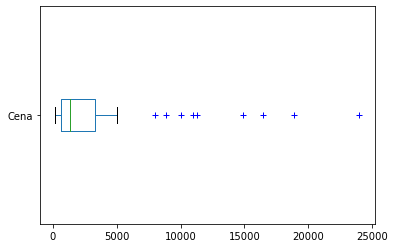

SD = <bound method Series.std of 0      9999
1      4499
2      3299
3      3299
4      4999
      ...  
76     7999
77    18890
78    16490
79    14852
80    24000
Name: Cena, Length: 81, dtype: int64>
SD = <bound method Series.std of 0     82
1     65
2     55
3     55
4     55
      ..
76    75
77    75
78    75
79    75
80    82
Name: Przekątna ekranu, Length: 81, dtype: int64>
SD = <bound method Series.std of 0     4
1     4
2     4
3     4
4     4
     ..
76    3
77    4
78    4
79    4
80    4
Name: Liczba złączy HDMI, Length: 81, dtype: int64>
SD = <bound method Series.std of 0     228
1     118
2     111
3     111
4     140
     ... 
76    116
77    410
78    409
79    272
80    579
Name: Pobór mocy, Length: 81, dtype: int64>


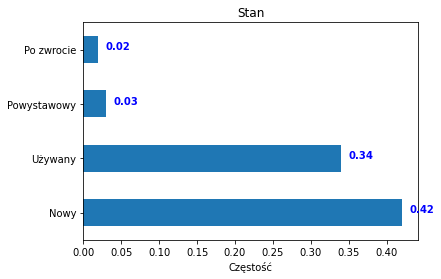

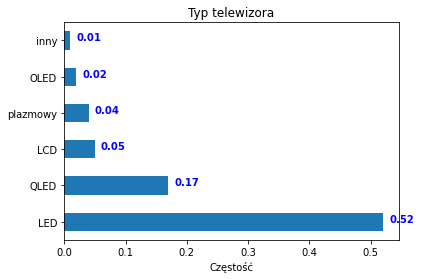

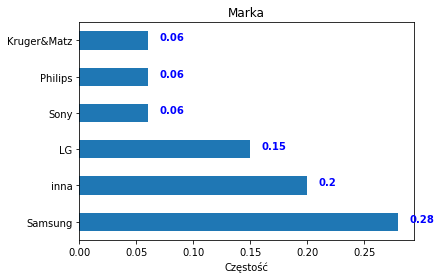

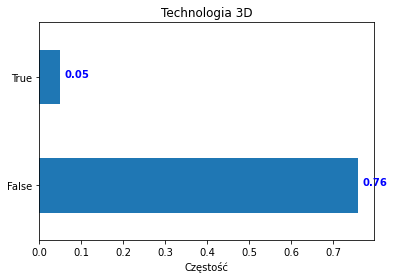

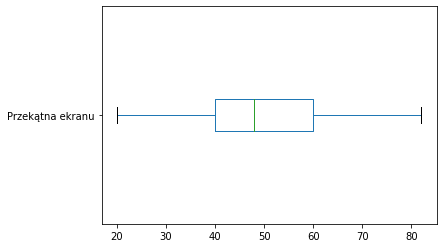

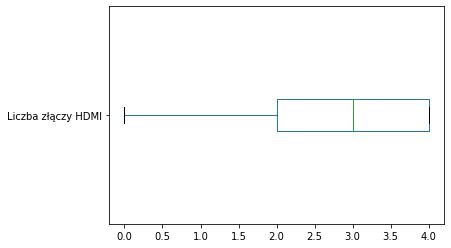

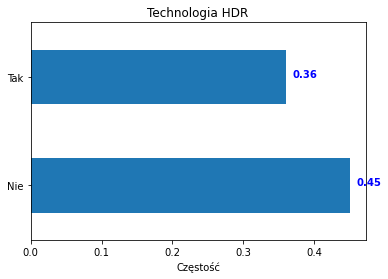

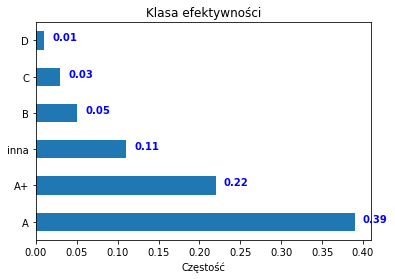

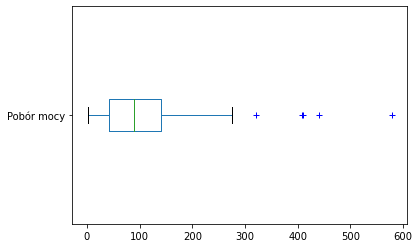

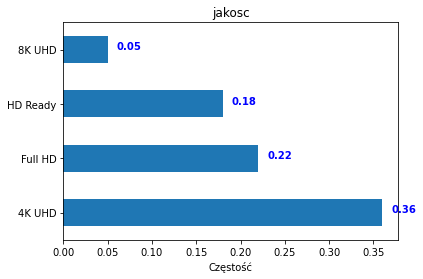

In [10]:
#stystki opisowe
for column in df:
    try:
        ax = df[column].plot(kind = "box" ,vert = False , sym = "b+" )
        #print(df[column].describe())
        plt.savefig(f"figs/{column}.jpg")
        plt.show()
        text = df[column].describe().to_latex()
        save_to_latex(text, f"{column}_stat")
        print(f"SD = {df[column].std}")
      
    except:
        TypeError
        ax = df[column].value_counts().div(100).plot(kind = "barh",title= column )
        #print(df[column].value_counts().div(100))
        ax.set_xlabel("Częstość")
        for i, v in enumerate(df[column].value_counts().div(100)):
             ax.text(v + 0.01, i , str(v), color='blue', fontweight='bold')
        plt.savefig(f"figs/{column}.jpg")
        plt.show()

In [11]:
#przygotwanie danych do regresji 
#usuniecie obserwacji odstajacych 
count = df["Cena"]
kwartyl = count.quantile(0.85)
drogie  = count > kwartyl
df = df.drop(drogie.loc[drogie].index)
#df = df.drop("Liczba złączy HDMI" , axis= 1)

regresion_data = pd.get_dummies(df, drop_first=True)
#usunac brakujace dane 
regresion_data = regresion_data.drop("jakosc_8K UHD", axis=1)
#to save unchanged dataframe
df_initial= df

<h3>Macierz korelacji 

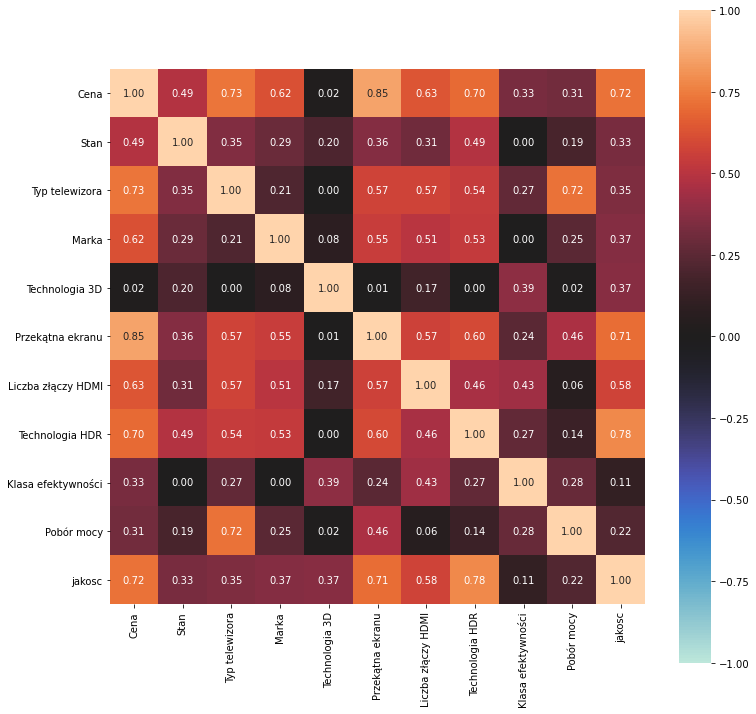

In [12]:
%matplotlib inline
corr_matix  = associations(df,nan_strategy= "drop_features",plot = False, figsize=(12,12))
ax = corr_matix["ax"]

plt.savefig("figs/macierzkorelacji.jpg")

<h3>Model liniowy

In [13]:
Y = regresion_data["Cena"]
X = regresion_data.iloc[:,1:]

X = sm.add_constant(X).astype(float)

model = sm.OLS(Y,X)
result = model.fit()

result.summary()
save_to_latex(result.summary(),"first_model")

<h3> Wstepna analiza modelu 

<Figure size 720x720 with 0 Axes>

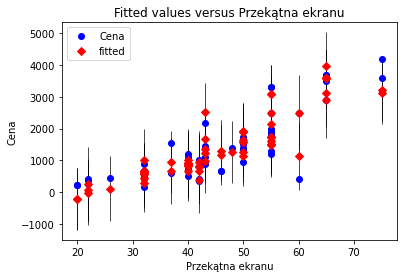

In [14]:
%matplotlib inline
plt.figure( figsize = (10,10))
plot = sm.graphics.plot_fit(result,1)
plt.savefig("figs/wtepna_analiza.jpg")

<h3> Poprawki do modelu</h3>

*  Zbadnie wspoliniowosci 
*  Usuniecie zmiennych nie znaczacych stystycznie metoda wsteczna krokową 

In [15]:
def variance_inflation_factor(exog, exog_idx):
    """variance inflation factor, VIF, for one exogenous variable
    https://en.wikipedia.org/wiki/Variance_inflation_factor
    """
    k_vars = exog.shape[1]
    x_i = exog.iloc[:, exog_idx]
    mask = np.arange(k_vars) != exog_idx
    x_noti = exog.iloc[:, mask]
    r_squared_i = sm.OLS(x_i, x_noti).fit().rsquared
    vif = 1. / (1. - r_squared_i)
    return vif

In [16]:
#wspoliniowsc 
vif_list = []
for i in range(X.shape[1]):
    vif = variance_inflation_factor(X,i)
    vif_list.append((X.iloc[:,i].name,vif))
vif_list = pd.DataFrame(vif_list)
save_to_latex(vif_list.to_latex(),"VIF")
#nie ma wyskoiej wpołsliniowsci w zmiennych
#wartosc 100 dal const wynika z powodu skalowania.
#https://stats.stackexchange.com/questions/332428/regression-model-constant-causes-multicollinearity-warning-but-not-in-standardi/332597#332597

In [17]:
stan_f = "(Stan_Używany = Stan_Powystawowy = Stan_Po zwrocie )"
typ_f = "(Typ telewizora_LED = Typ telewizora_OLED = Typ telewizora_QLED = Typ telewizora_inny = Typ telewizora_plazmowy = 0)"
marka_f = "(Marka_LG=Marka_Philips=Marka_Samsung= Marka_Sony=Marka_inna =0)"
klasa_f = "(Klasa efektywności_A+ =Klasa efektywności_B = Klasa efektywności_C = Klasa efektywności_D=Klasa efektywności_inna=0)"
jakosc_f = "(jakosc_Full HD= jakosc_HD Ready = 0)"
hdr_f = "(Technologia HDR_Tak = 0)"
tech3D_f = "(Technologia 3D_True=0)"

testy_f = [stan_f,typ_f,marka_f,klasa_f,jakosc_f,hdr_f,tech3D_f]
zmienne_ciagle = ["Pobór mocy","Przekątna ekranu","Liczba złączy HDMI","const"]

def run_test(zmienne_kategoryczne,zmienne_ciagle , model):
    wynik_test = []
    #F test dla dummy zmiennej kategorycznej 
    for test in zmienne_kategoryczne:
        try:
            wynik = model.f_test(test)
            name = test[1:].split(sep = "_")[0]
            s = f"{name} nie jest znacząca"
            s1 = f"{name} jest znaczące"
            wynik_test.append((name, wynik.pvalue))
            #print(f"{s1 if wynik.pvalue < 0.05 else s}")
        except:pass
    #t test dla zmiennych ciaglych 
    for ttest in zmienne_ciagle:
        try:
            wynik_test.append((ttest,model.pvalues[ttest]))
        except:pass
    return wynik_test
        
wynik_test = run_test(testy_f,zmienne_ciagle,result)
wynik_pd = pd.DataFrame(wynik_test)
print(wynik_pd)
save_to_latex(wynik_pd.to_latex(),"Testy_istotnosci")

                     0                     1
0                 Stan   0.13544747232794202
1       Typ telewizora  0.008491797331009644
2                Marka   0.40890046107407024
3   Klasa efektywności    0.5532931630889933
4               jakosc    0.8667612754589771
5      Technologia HDR    0.8050348162403695
6       Technologia 3D    0.6797816760227706
7           Pobór mocy              0.753333
8     Przekątna ekranu            9.6261e-07
9   Liczba złączy HDMI              0.974711
10               const              0.121632


In [18]:
#metoda przyjmuje df oraz liste tupli (nazwa,p-value)
def metoda_wsteczna_krokowa(df, pvalue_list):
    najwieksza = max(pvalue_list, key=itemgetter(1))
    #usuwanie 
    df = df.drop(najwieksza[0], axis= 1)
    return df 

In [19]:
#safeguard from globals 
df2 = df

In [20]:
#while na metode wsteczna krokowa 
while True:
    najwieksza =  max(wynik_test, key=itemgetter(1))
    #gdy wszystkie zmeinne sa stsystcznie znaczace koniec metody krokowej
    if najwieksza[1] < 0.1: break
    print(f"usuwana zmienna to {najwieksza[0]}, z pvalue rowne {najwieksza[1]}")
    df2 = metoda_wsteczna_krokowa(df2,wynik_test)
    regresion_data2 = pd.get_dummies(df2, drop_first=True)
    Y = regresion_data2["Cena"]
    X = regresion_data2.iloc[:,1:]
    X = sm.add_constant(X).astype(float)
    result2 = sm.OLS(Y,X).fit()
    wynik_test = run_test(testy_f,zmienne_ciagle,result2)   
result2.summary()
save_to_latex(result2.summary(),"model_poprawiony")
#wszystkie zmienne sa znaczace 

usuwana zmienna to Liczba złączy HDMI, z pvalue rowne 0.974711137133669
usuwana zmienna to jakosc, z pvalue rowne 0.8627778996805936
usuwana zmienna to Technologia 3D, z pvalue rowne 0.792828352613247
usuwana zmienna to Pobór mocy, z pvalue rowne 0.7259775248299482
usuwana zmienna to Technologia HDR, z pvalue rowne 0.5133421065955824
usuwana zmienna to Marka, z pvalue rowne 0.20835637190097164
usuwana zmienna to Klasa efektywności, z pvalue rowne 0.16149461615509111


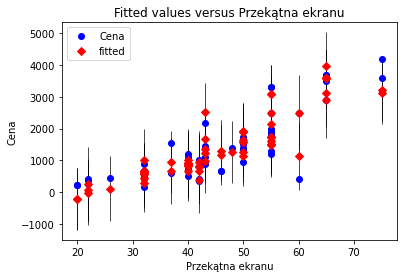

In [21]:
plot = sm.graphics.plot_fit(result,1)
plt.savefig("figs/poprawion_model.jpg")

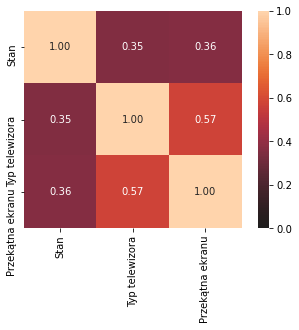

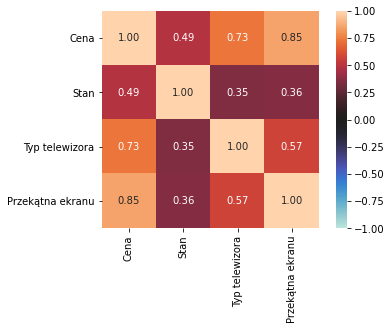

efekt kataliz w parach (i,j) []


In [22]:
def sign(x):
    return math.copysign(1, x)
#macierz korelacji zmeinnych egzodoniczych
R_corr = associations(df2.iloc[:,1:],nan_strategy= "drop_features")
R_corr = np.array(R_corr["corr"])

R = associations(df2,nan_strategy= "drop_features")
R = np.array(R["corr"].iloc[:,0])[1:]

R_sorted = R.argsort()
r_0 = R[R_sorted]
r = R_corr[R_sorted]

pairs = []
for i in range(r.shape[0]):
    for j in range(r.shape[0]):
        if abs(r_0[i]) < abs(r_0[j]):
            r_ij = r[i, j] * sign(r_0[i]) * sign(r_0[j])
            if r_ij > (abs(r_0[i]) / abs(r_0[j])) or r_ij < 0:
                pairs.append((i, j))

if pairs == None: print("Brak efektu katalizy ")
else: print(f"efekt kataliz w parach (i,j) {pairs}")
#brak katalizatorów 

In [23]:
#Normalność rozkładu składnika losowego.
Jarque_Bera_pv = float(result2.summary().tables[2].data[2][3])
if Jarque_Bera_pv >0.1: print("rozklad reszt nie jest normalny ")
else:print("rozklad reszt jest normalny")

rozklad reszt jest normalny


In [24]:
def sort_by(data, sorter):
      sotred_sorter ,sorted_arr = zip( *sorted(zip(sorter,data)))
      return np.array(sorted_arr)
def p_value_test_seri(reszty, Y):
    reszty = np.array(reszty.resid)
    sortedd = sort_by(reszty,Y)
    normalize = np.vectorize(lambda a: 1 if a>0 else 0)
    sortedd = normalize(sortedd)
    series_pvalue = sm.stats.Runs(sortedd).runs_test()
    return series_pvalue[1]


In [25]:
#test seri (Wald)

print(f"{p_value_test_seri(result2,Y)} P-value testu seri")
#model nie jest liniowy 

0.8216985501200023 P-value testu seri


In [26]:
p_value_RESET = sm.stats.linear_reset(result2)
p_value_RESET
#Brak podstaw do odrzucenia h_0 pierwotna postac modelu jest poprawna 



<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[27.71026936]], p-value=9.611506453997187e-07, df_denom=2>

In [27]:
#transformcaja ceny do log 
Y = np.log(regresion_data2["Cena"])
X = regresion_data2.iloc[:,1:]
X = sm.add_constant(X).astype(float)
result2_log = sm.OLS(Y,X).fit()
result2_log.summary()
save_to_latex(result2_log.summary(), "model_logarytm")

In [28]:
print(f"{p_value_test_seri(result2_log ,Y)} test seri dla modelu z log")
#transformacja modelu jest poprawna 

0.0010945248619090076 test seri dla modelu z log


In [29]:
#po korecji na log model liniowy nie jest juz najlepszy 
p_value_RESET = sm.stats.linear_reset(result2_log,2)
p_value_RESET

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[0.1804874]], p-value=0.6709547118839503, df_denom=1>

In [30]:
#model z przekatna do kwadratu 
Y = np.log(regresion_data2["Cena"])
X = regresion_data2.iloc[:,1:]
X["Przekątna ekranu"] = X["Przekątna ekranu"]**2
X = sm.add_constant(X).astype(float)
result2_log_sq = sm.OLS(Y,X).fit()
print(result2_log_sq.summary())

save_to_latex(result2_log_sq.summary(), "model_log_kwadrat")
print(f"{p_value_test_seri(result2_log ,Y)} test seri dla modelu z log")
#transformacja modelu jest poprawna 

#tearz postac modelu jest juz poprawna 
p_value_RESET = sm.stats.linear_reset(result2_log_sq,3)
print(p_value_RESET)

#breuschpagan test 
breush = sm.stats.diagnostic.het_breuschpagan(result2_log_sq.resid, X)
#p-value of lagrange multiplier test
lm_pvalue = breush[1]
#p-value for the f-statistic
f_pvalue = breush[3]
print(f" Brauch{lm_pvalue,f_pvalue}")
#h_0 =homoskedasticity , odrzucam wiec jest heterodastycznosc
#white test 
white = sm.stats.diagnostic.het_white(result2_log_sq.resid,X)
lm_pvalue = white[1]
#p-value for the f-statistic
f_pvalue = white[3]
print(f" White {lm_pvalue,f_pvalue}")
#h_0 =homoskedasticity , odrzucam wiec jest heterodastycznosc
#wystepuje niska heterodastycznosc 

                            OLS Regression Results                            
Dep. Variable:                   Cena   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     27.08
Date:                Sun, 05 Jul 2020   Prob (F-statistic):           8.33e-18
Time:                        13:18:43   Log-Likelihood:                -25.902
No. Observations:                  69   AIC:                             71.80
Df Residuals:                      59   BIC:                             94.14
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

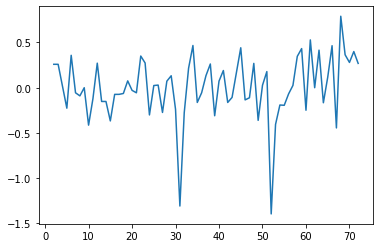

In [31]:
result2_log_sq.resid.plot()

plt.savefig("figs/reszty_log_sq.jpg")
#wynika to z pojedynczych obserwacji 



In [32]:
#poprawka na heterodastycznosc
X2 = X
X2["Przekątna ekranu"] = X["Przekątna ekranu"] / np.sqrt(np.exp(result2_log_sq.resid)**2)
Y2 = np.log(np.exp(Y)/ np.sqrt(np.exp(result2_log_sq.resid)**2))


In [33]:
result2_log_sq_het = sm.OLS(Y2,X2).fit()
result2_log_sq_het.summary()

save_to_latex(result2_log_sq_het.summary(), "model_log_sq_homo")

In [34]:
breush = sm.stats.diagnostic.het_breuschpagan(result2_log_sq_het.resid, X)
#p-value of lagrange multiplier test
lm_pvalue = breush[1]
#p-value for the f-statistic
f_pvalue = breush[3]
print(f" Brauch {lm_pvalue,f_pvalue}")
#h_0 =homoskedasticity , odrzucam wiec jest heterodastycznosc


#white test 
white = sm.stats.diagnostic.het_white(result2_log_sq_het.resid,X)
lm_pvalue = white[1]
#p-value for the f-statistic
f_pvalue = white[3]
print(f" White {lm_pvalue,f_pvalue}")



 Brauch (3.140388461885039e-07, 4.953662458242724e-12)
 White (2.2945588282568748e-05, 4.777562405746083e-10)


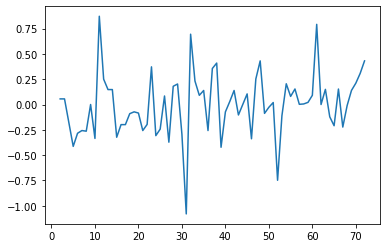

In [35]:
result2_log_sq_het.resid.plot()


plt.savefig("figs/reszty_log_sq_hetero.jpg")

In [36]:
#model jest liniowy
print(f"{p_value_test_seri(result2_log_sq_het,Y)} test seri")

2.6386188579970305e-05 test seri


In [37]:
#postac modelu jest prawidlowa
p_value_RESET = sm.stats.linear_reset(result2_log_sq_het,3)
p_value_RESET


<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[8.8332306]], p-value=0.01207503353496347, df_denom=2>

In [38]:
#test Chowa
from sklearn.model_selection import train_test_split
def chow_test(X , Y):
    n= X.shape[0]
    k = X.shape[1]
    x_1, x_2 , y_1, y_2 =  train_test_split(X,Y,test_size=0.5)
    
    ols_1 = sm.OLS( y_1,x_1)
    ols_2 = sm.OLS( y_2,x_2)
    mod_1 = ols_1.fit()
    mod_2 = ols_2.fit()
    rsk_1 = mod_1.ssr
    rsk_2 = mod_2.ssr
    rsk = sm.OLS(Y, X).fit()
    rsk = rsk.ssr
    r_1 = k - 1
    r_2 = n - 2 * (k -1)
    f_stat = ((rsk - rsk_1 - rsk_2) / (rsk_1 + rsk_2)) * (r_2 / r_1)
    #return p-value of F statistic
    return stats.f.sf(f_stat, dfn=r_1, dfd=r_2)

In [39]:
chow_list = []
for i in range(20):
    chow_list.append(chow_test(X2,Y2))
chow_list
#test chowa pokazuje ze model nie jest stabilny, ponieważ jest mało danych i duża wariancja w dancyh.

[0.3212254434435945,
 0.001343873020050195,
 0.028924044911825673,
 1.58781733609053e-05,
 0.02059132002564599,
 0.0007728029864326307,
 0.14595913608706587,
 0.06849378026357827,
 0.0010656147940581952,
 0.3470785752328491,
 0.6325369622698582,
 0.48514519962295255,
 0.016373902850327953,
 0.017171033629302165,
 0.20000052956752384,
 0.21699479967269822,
 0.19254559106980398,
 0.0024861031461344135,
 0.06211706899104807,
 0.09452892067125386]

In [40]:
#wspołliniowosc 
vif_list = []
for i in range(X2.shape[1]):
    vif = variance_inflation_factor(X2,i)
    vif_list.append((X2.iloc[:,i].name,vif))
vif_list 
#poza const nie ma wysokiej wpołliniowosci 

[('const', 19.751096599853554),
 ('Przekątna ekranu', 1.2967734278112613),
 ('Stan_Po zwrocie', 1.0544684157460662),
 ('Stan_Powystawowy', 1.5948010145355067),
 ('Stan_Używany', 1.3879348950594765),
 ('Typ telewizora_LED', 3.511562041170873),
 ('Typ telewizora_OLED', 1.759289202476175),
 ('Typ telewizora_QLED', 3.1901534859977843),
 ('Typ telewizora_inny', 1.1848862798512998),
 ('Typ telewizora_plazmowy', 1.89202020130632)]

In [41]:
def collinearity_test(X):
        collinear = []
        for i in range(X.shape[1]):
            x = X.drop(X.columns[i], axis=1)
            model = sm.OLS(X.iloc[:,i],x)
            res = model.fit()
            if res.rsquared  > 0.9:
                collinear.append(X.columns[i])
        return collinear

In [42]:
coliniar = collinearity_test(X2)
coliniar
#wysoka wspolniwososc const wynika ze złego scalowania

['const']

In [43]:
#koincydencja 
def model_coincidence(X_w,Y):
    X = np.array(X_w)
    Y = np.array(Y)
    r_0 = [np.corrcoef(X[:, i], Y)[0][1] for i in range(X.shape[1])]
    x_t_x_inverse = np.linalg.inv(X.T @ X)
    a = x_t_x_inverse @(X.T@Y)
    results = []
    for r in range(X.shape[1]):
        if sign(r_0[r]) != sign(a[r]):
            results.append(
                dict(variable=X_w.columns[r], a=a[r], r=r_0[r])
            )
    return results




In [44]:
koincydencja = model_coincidence(X2,Y2)
koincydencja
#koincydecja w dummy varieble nie jest znaczaca, 


[{'variable': 'const', 'a': 5.699255350628206, 'r': nan},
 {'variable': 'Typ telewizora_LED',
  'a': 0.8278866585456797,
  'r': -0.179241207762127},
 {'variable': 'Typ telewizora_plazmowy',
  'a': 0.5140352297157307,
  'r': -0.01789614388591152}]

<h3> Wybór modelu </h3>
Wszyskie tessty zakonczone. 
Otrzymany model ma postać: 
log(Cena) = a + a_1 * przekątna_ekranu^2 + a_3 *stan + a_4 * typ
Teraz zbiórczo testy dla tego modelu 
oraz przwidywania z 95% pewnoscia 
poziom istotnosci modelu to apha = 0.1 


<h3>Testowanie Modelu oraz Pełny opis</h3>

*  Współczynnik determinacji.
*  Efekt katalizy.
*  Normalność rozkładu składnika losowego.
*  Istotność zmiennych.
*  Testy dodanych (pominiętych zmiennych).
*  Obserwacje odstające.
*  Test liczby serii (uporządkować obserwacje!!).
*  Test RESET.19.Testowanie heteroskeastyczności.
*  Test Chowa (wraz z komentarzem na temat podziału próbki na dwie grupy).
*  Współliniowość.
*  Koincydencja.
*  Interpretacja parametrów modelu (tam gdzie trzeba elastyczność).
*  predykcja wraz z 95% przedziałem ufności.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     27.76
Date:                Sun, 05 Jul 2020   Prob (F-statistic):           4.69e-18
Time:                        13:18:44   Log-Likelihood:                -17.733
No. Observations:                  69   AIC:                             55.47
Df Residuals:                      59   BIC:                             77.81
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

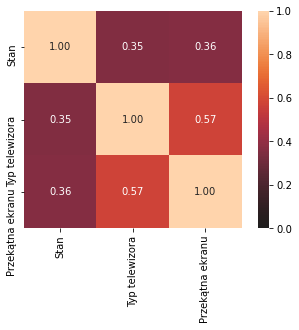

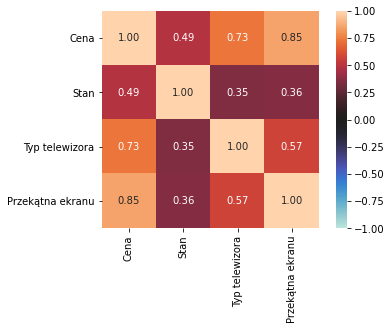

In [45]:
#wczytanie danych i stworzenie dummy variable
Dane = pd.get_dummies(df2, drop_first=True)
#Czyste przypisanie zmeinyych endo i egzo
Y = Dane["Cena"]
X = Dane.iloc[:,1:]
X = sm.add_constant(X).astype(float)

#tranformacja danych 
Y = np.log(Y)
X["Przekątna ekranu"] = X["Przekątna ekranu"]**2
#początkowy fit
final_model = sm.OLS(Y,X).fit()

#korekcja heterodastyczności 
X["Przekątna ekranu"] = X["Przekątna ekranu"] / np.sqrt(np.exp(final_model.resid)**2)
Y = np.log(np.exp(Y)/ np.sqrt(np.exp(final_model.resid)**2))

final_model = sm.OLS(Y,X).fit()
print(final_model.summary())
#zapisane  modelu 
save_to_latex(final_model.summary(), "final_model")
print("\n\n\n")
#Współczynik Determinacji 
print(f"F-vaule dla modelu wynosi:{final_model.f_pvalue} \n Brak podstaw do orzucenia H_0\n R^2 jest statystycznie znaczące")
print("\n\n\n")
#Badanie efektu katalizy
R_corr = associations(df2.iloc[:,1:],nan_strategy= "drop_features")
R_corr = np.array(R_corr["corr"])

R = associations(df2,nan_strategy= "drop_features")
R = np.array(R["corr"].iloc[:,0])[1:]

R_sorted = R.argsort()
r_0 = R[R_sorted]
r = R_corr[R_sorted]

pairs = []
for i in range(r.shape[0]):
    for j in range(r.shape[0]):
        if abs(r_0[i]) < abs(r_0[j]):
            r_ij = r[i, j] * sign(r_0[i]) * sign(r_0[j])
            if r_ij > (abs(r_0[i]) / abs(r_0[j])) or r_ij < 0:
                pairs.append((i, j))
print(f"efekt kataliz występuje w parach (i,j) {pairs}")
print("\n\n\n")
#Normalność reszt 
Jarque_Bera_pv = float(final_model.summary().tables[2].data[2][3])
print(f"P-value dla Jarque_Bera wynosi {Jarque_Bera_pv} \nBrak podstaw do odrzucenia H_0,rozkład reszt jest normalny")
print("\n\n\n")

#test istotnosci zmiennych oraz testy danych usuniętych
stan_f = "(Stan_Używany = Stan_Powystawowy = Stan_Po zwrocie )"
typ_f = "(Typ telewizora_LED = Typ telewizora_OLED = Typ telewizora_QLED = Typ telewizora_inny = Typ telewizora_plazmowy )"
testy_f = [stan_f,typ_f]
zmienne_ciagle = ["Przekątna ekranu","const"]

wynik_test = run_test(testy_f,zmienne_ciagle, final_model)
wynik_pd = pd.DataFrame(wynik_test)
for wyn in wynik_test:
    print(wyn)
print("Wszystkie zmienne są statystycznie istotne na podstawie metody wstecznej krokowej")
save_to_latex(wynik_pd.to_latex(),"Testy_istotnosci")
print("\n\n\n")

In [46]:
#test zmeinnych odrzuconych 
df_initial = df_initial.drop(list(df2), axis = 1)
Data_odrzucone = pd.get_dummies(df_initial, drop_first=True)
X_2 = Data_odrzucone
X_2 = sm.add_constant(X_2).astype(float)
Y_2 = Y

model_odrzucone = sm.OLS(Y_2,X_2).fit()
print(model_odrzucone.summary())
save_to_latex(model_odrzucone.summary(), "model_odzrucony")
print("\n\n\n")
marka_f = "(Marka_LG=Marka_Philips=Marka_Samsung= Marka_Sony=Marka_inna =0)"
klasa_f = "(Klasa efektywności_A+ =Klasa efektywności_B = Klasa efektywności_C = Klasa efektywności_D=Klasa efektywności_inna=0)"
jakosc_f = "(jakosc_Full HD= jakosc_HD Ready = 0)"
hdr_f = "(Technologia HDR_Tak = 0)"
tech3D_f = "(Technologia 3D_True=0)"
testy_f = [marka_f,klasa_f,jakosc_f,hdr_f,tech3D_f]
zmienne_ciagle = ["Pobór mocy","Liczba złączy HDMI","const"]
testy_odrzucone = run_test(testy_f,zmienne_ciagle,model_odrzucone)
print(testy_odrzucone)
save_to_latex(pd.DataFrame(testy_odrzucone).to_latex(), "p_value_odrzucone_sdtmodel")

while True:
    najwieksza =  max(testy_odrzucone, key=itemgetter(1))
    #gdy wszystkie zmeinne sa stsystcznie znaczace koniec metody krokowej
    if najwieksza[1] < 0.1: break
    print(f"usuwana zmienna to {najwieksza[0]}, z pvalue rowne {najwieksza[1]}")
    df_initial = metoda_wsteczna_krokowa(df_initial,testy_odrzucone)
    Data_odrzucone = pd.get_dummies(df_initial, drop_first=True)
    X_Odrz = Data_odrzucone.iloc[:,1:]
    X_Odrz = sm.add_constant(X_Odrz).astype(float)
    model_odrzucone = sm.OLS(Y_2,X_Odrz).fit()
    testy_odrzucone = run_test(testy_f,zmienne_ciagle,model_odrzucone)   
print(model_odrzucone.summary())
save_to_latex(model_odrzucone.summary(),"model_odrzucony")
#model ten jest gorszy od modelu ze zmeinnymi z wyjsciowego modelu.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     9.591
Date:                Sun, 05 Jul 2020   Prob (F-statistic):           2.50e-10
Time:                        13:18:44   Log-Likelihood:                -29.570
No. Observations:                  69   AIC:                             91.14
Df Residuals:                      53   BIC:                             126.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [47]:
#test seri 
print(p_value_test_seri(final_model ,Y))
print("Brak podstaw do odrzucenia H_0 na poziomie 0.1\n Model jest linowy ")
print("\n\n\n")

#test RESET
print(sm.stats.linear_reset(final_model,2))
print("Brak podstaw do odrzucenia H_0 na poziomie 0.1\n Postać modelu jest poprawna ")
print("\n\n\n")

#Testowanie heteroskeastyczności
breush = sm.stats.diagnostic.het_breuschpagan(final_model.resid, X)
lm_pvalue = breush[1]
f_pvalue = breush[3]
print(f" P-value dla Breusch-Pagan ={lm_pvalue}, F-value = {f_pvalue}")
print("Brak podstaw do odrzucenia H_0 na poziomie 0.1\n Model jest homodekatyczny na podstawie testu Breusch-Pagan")
print("\n\n\n")
white = sm.stats.diagnostic.het_white(final_model.resid,X)
lm_pvalue = white[1]
#p-value for the f-statistic
f_pvalue = white[3]
print(f" P-value dla White'a ={lm_pvalue}, F-value = {f_pvalue}")
print("Brak podstaw do odrzucenia H_0 na poziomie 0.1\n Model jest homodekatyczny na podstawie testu White'a")
print("\n\n\n")
#Test Chowa 
chow_list = []
for i in range(20):
    chow_list.append(chow_test(X,Y))
chow_pd = pd.DataFrame(chow_list)
save_to_latex(chow_pd.to_latex(), "chow_final")
print(chow_list)
print("Model nie jest stabliny")
print("\n\n\n")
#Współlinowość 
vif_list = []
for i in range(X.shape[1]):
    vif = variance_inflation_factor(X,i)
    vif_list.append((X.iloc[:,i].name,vif))
vif_list_pd = pd.DataFrame(vif_list)
#save to latex
print(vif_list)
print("Nie ma wpółlinowości między zmienymi(dla wszytkich zmeinnych vif < 5, ingorujemy const")
print("\n\n\n")
coliniar = collinearity_test(X)
coliniar_pd = pd.DataFrame(coliniar)

print(coliniar)
print("Nie ma wyskoiej współliniowiści, ingnorujemy const")
print("\n\n\n")
#Koincydencja 
koincydencja = model_coincidence(X2,Y2)
koincydencja_pd = pd.DataFrame(koincydencja)
print(koincydencja)

#Interpretacja Parametrów
#w PDF 

0.00
Brak podstaw do odrzucenia H_0 na poziomie 0.1
 Model jest linowy 




<Wald test (chi2): statistic=[[7.99217329]], p-value=0.004697998878662177, df_denom=1>
Brak podstaw do odrzucenia H_0 na poziomie 0.1
 Postać modelu jest poprawna 




 P-value dla Breusch-Pagan =3.140388461885039e-07, F-value = 4.953662458242724e-12
Brak podstaw do odrzucenia H_0 na poziomie 0.1
 Model jest homodekatyczny na podstawie testu Breusch-Pagan




 P-value dla White'a =2.2945588282568748e-05, F-value = 4.777562405746083e-10
Brak podstaw do odrzucenia H_0 na poziomie 0.1
 Model jest homodekatyczny na podstawie testu White'a




[0.0004486101659010369, 0.06844771017783449, 0.012720313782877201, 0.8099242983366114, 0.5097953900923814, 0.0931610521242215, 2.5601245143718073e-06, 0.3061418350168913, 0.11853665177876153, 0.10629255437156347, 3.5115798186298576e-05, 1.4174463986392216e-06, 0.05413056982038244, 0.00023465570293964446, 0.000642512462765969, 0.02375313465555952, 0.03912067444613241, 1.1626454

In [48]:
#Predykcje z 95% przedziałem ufności 
#default alpha is 0.05
prstd = final_model.get_prediction()
prstd.summary_frame()
mean = prstd.summary_frame().loc[:,"mean"]
#interwal dla obserwacji 
lower = prstd.summary_frame().loc[:,"obs_ci_lower"]
upper = prstd.summary_frame().loc[:,"obs_ci_upper"]

mean = np.array(np.exp(mean)*np.sqrt(np.exp(final_model.resid))).reshape(-1,1)
lower = np.array(np.exp(lower)).reshape(-1,1)#*np.sqrt(np.exp(final_model.resid))
upper = np.array(np.exp(upper)).reshape(-1,1)#*np.sqrt(np.exp(final_model.resid))
true =  np.array(Dane["Cena"]).reshape(-1,1)
Predictions = pd.DataFrame(np.concatenate([mean, lower, upper, true], axis=1), 
                           columns= ['Średnia wartosc','Dolna','Górna','Prawdziwa'])

save_to_latex(Predictions.to_latex(), "Tabela Predykcji")
print(Predictions)

    Średnia wartosc        Dolna        Górna  Prawdziwa
0       2477.346083  1174.160943  4944.613420     3299.0
1       2477.346083  1174.160943  4944.613420     3299.0
2        615.199526   378.295259  1513.229797      399.0
3       1755.097975   980.177779  4175.716966     2178.0
4        720.531276   410.408866  1636.248821      599.0
..              ...          ...          ...        ...
64       706.851938   354.604947  1423.254348     1549.0
65       615.836034   265.391430  1243.152119      950.0
66       952.694245   429.182524  1712.206178     1400.0
67       988.969597   424.452393  1693.559656     1720.0
68      1170.000553   472.174385  1883.748679     1899.0

[69 rows x 4 columns]


<function matplotlib.pyplot.show(*args, **kw)>

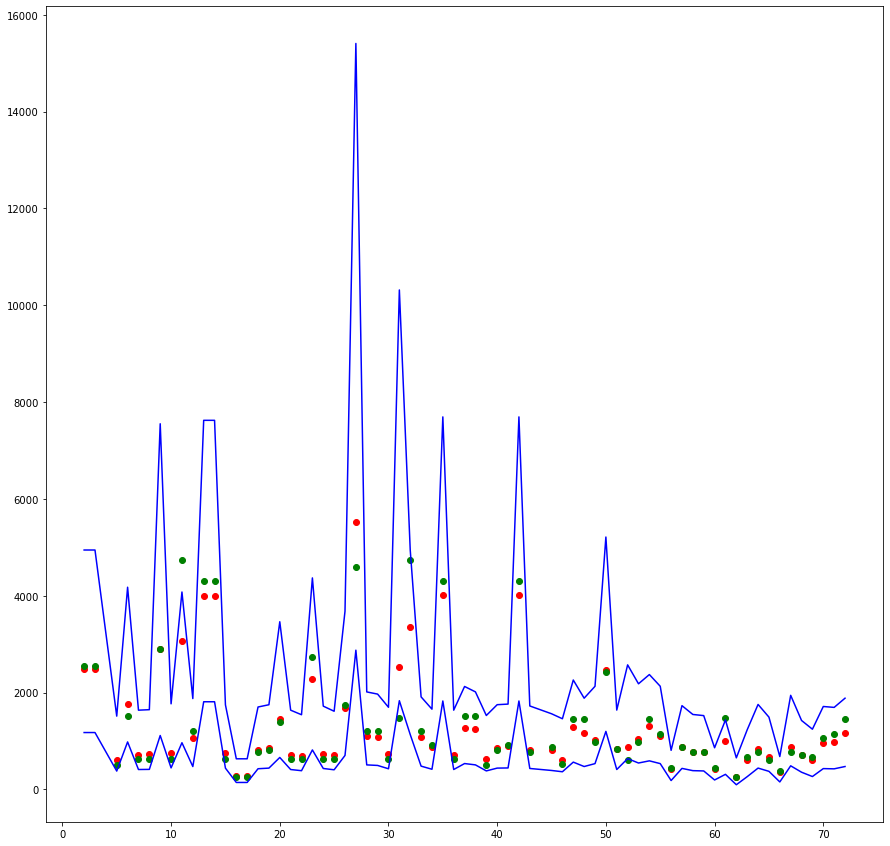

In [49]:
#sorting by true priece to beter visialize 
true = np.exp(Y)

plt.figure(figsize=(15,15))
plt.plot( Y.index , mean, "ro")
plt.plot( Y.index ,true , "go")
plt.plot( Y.index , upper, "b")
plt.plot( Y.index , lower, "b")

plt.savefig(f"figs/wykres_predykcji.jpg")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

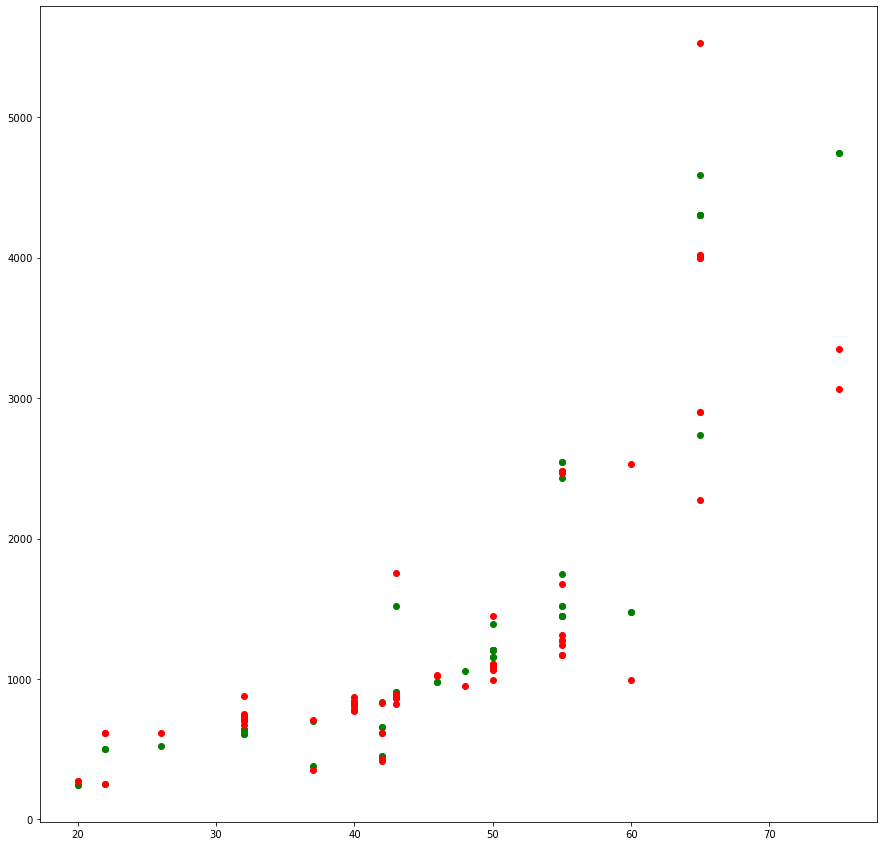

In [50]:
#plot przekatnej
plt.figure(figsize=(15,15))
plt.plot( Dane["Przekątna ekranu"],true ,  "go")
plt.plot(Dane["Przekątna ekranu"] , mean, "ro")
plt.savefig(f"figs/wykres_predykcji_doprzekntej.jpg")
plt.show